In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installation des dépendances
!pip install -q tensorflow pandas numpy scikit-learn matplotlib seaborn plotly shap

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("✅ Imports terminés")
print(f"TensorFlow version: {tf.__version__}")

✅ Imports terminés
TensorFlow version: 2.19.0


In [ ]:
# Chemins vers les fichiers
BASE_PATH = "/content/drive/MyDrive/F1RaceTraces_2025/"

# Chargement des CSVs principaux
circuits = pd.read_csv(f"{BASE_PATH}circuits.csv")
drivers = pd.read_csv(f"{BASE_PATH}drivers.csv")
races = pd.read_csv(f"{BASE_PATH}races.csv")
results = pd.read_csv(f"{BASE_PATH}results.csv")
lap_times = pd.read_csv(f"{BASE_PATH}lap_times.csv")
pit_stops = pd.read_csv(f"{BASE_PATH}pit_stops.csv")
status = pd.read_csv(f"{BASE_PATH}status.csv")
qualifying = pd.read_csv(f"{BASE_PATH}qualifying.csv")
constructors = pd.read_csv(f"{BASE_PATH}constructors.csv")

# Données d'incidents
safety_cars = pd.read_csv(f"{BASE_PATH}safety_cars.csv")
red_flags = pd.read_csv(f"{BASE_PATH}red_flags.csv")
fatal_drivers = pd.read_csv(f"{BASE_PATH}fatal_accidents_drivers.csv")

print("✅ Données chargées")
print(f"Courses: {len(races)} | Pilotes: {len(drivers)} | Résultats: {len(results)}")
print(f"\nAperçu results:")
print(results.head(3))
print(f"\nColonnes status: {status.columns.tolist()}")


✅ Données chargées
Courses: 1149 | Pilotes: 864 | Résultats: 27198

Aperçu results:
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452           218.3         1  
1         41    3       1:27.739         217.586         1  
2         41    5       1:28.090         216.719         1  

Colonnes status: ['statusId', 'status']


In [ ]:
# Fusion des données principales
df = results.merge(
    races[['raceId', 'year', 'circuitId', 'name', 'date']],
    on='raceId',
    how='left'
)

df = df.merge(
    drivers[['driverId', 'driverRef', 'nationality', 'code']],
    on='driverId',
    how='left'
)

df = df.merge(
    circuits[['circuitId', 'circuitRef', 'location', 'country', 'lat', 'lng']],
    on='circuitId',
    how='left'
)

df = df.merge(
    status[['statusId', 'status']],
    on='statusId',
    how='left'
)

# Ajouter données constructeur
df = df.merge(
    constructors[['constructorId', 'constructorRef', 'nationality']],
    on='constructorId',
    how='left',
    suffixes=('', '_constructor')
)

print(f" Dataset fusionné: {df.shape}")
print(f"Colonnes disponibles: {df.columns.tolist()}")

# Création de la variable cible (5 classes d'incidents)
def classify_incident(status_text):
    if pd.isna(status_text):
        return 'safety_car'

    status_lower = str(status_text).lower()

    # Collision / Accident
    if any(word in status_lower for word in ['accident', 'collision', 'crash', 'spun off', 'damage']):
        return 'collision'

    # Panne moteur
    elif any(word in status_lower for word in ['engine', 'power unit', 'electrical', 'gearbox', 'transmission']):
        return 'panne_moteur'

    # Problème pneus
    elif any(word in status_lower for word in ['tyre', 'tire', 'puncture', 'wheel']):
        return 'probleme_pneus'

    # Sortie de piste
    elif any(word in status_lower for word in ['spun', 'off track']):
        return 'sortie_piste'

    # Course terminée normalement ou avec safety car
    elif any(word in status_lower for word in ['finished', '+', 'lap']):
        return 'safety_car'

    else:
        return 'safety_car'

df['incident_type'] = df['status'].apply(classify_incident)

print("\n Distribution des incidents:")
print(df['incident_type'].value_counts())

# Features numériques (utiliser les VRAIES colonnes)
df['grid_position'] = pd.to_numeric(df['grid'], errors='coerce').fillna(20)
df['final_position'] = pd.to_numeric(df['position'], errors='coerce').fillna(20)
df['laps_completed'] = df['laps']
df['points_scored'] = df['points']

# Nouvelles features
df['position_change'] = df['grid_position'] - df['final_position']
df['dnf'] = df['position'].isna().astype(int)

# Encodage
le_circuit = LabelEncoder()
le_driver = LabelEncoder()
le_constructor = LabelEncoder()
le_incident = LabelEncoder()

df['circuit_encoded'] = le_circuit.fit_transform(df['circuitRef'].fillna('unknown'))
df['driver_encoded'] = le_driver.fit_transform(df['driverRef'].fillna('unknown'))
df['constructor_encoded'] = le_constructor.fit_transform(df['constructorRef'].fillna('unknown'))
df['incident_encoded'] = le_incident.fit_transform(df['incident_type'])

print("\n Features préparées")
print(f"Classes d'incidents: {le_incident.classes_}")

 Dataset fusionné: (27198, 33)
Colonnes disponibles: ['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid', 'position', 'positionText', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId', 'year', 'circuitId', 'name', 'date', 'driverRef', 'nationality', 'code', 'circuitRef', 'location', 'country', 'lat', 'lng', 'status', 'constructorRef', 'nationality_constructor']

 Distribution des incidents:
incident_type
safety_car        20524
panne_moteur       3525
collision          2808
probleme_pneus      341
Name: count, dtype: int64

 Features préparées
Classes d'incidents: ['collision' 'panne_moteur' 'probleme_pneus' 'safety_car']


In [ ]:
# BLOC 4 : Création des séquences temporelles (FIX)

print(" Création des séquences temporelles...")

# Merger lap_times avec results pour avoir resultId
lap_data = lap_times.merge(
    results[['resultId', 'raceId', 'driverId']],
    on=['raceId', 'driverId'],
    how='inner'
)

print(f"Lap times avec resultId: {len(lap_data)}")

# Nettoyage des millisecondes
def clean_milliseconds(value):
    if pd.isna(value):
        return np.nan

    # Si déjà un nombre
    if isinstance(value, (int, float)):
        return float(value)

    # Si string
    value_str = str(value).strip()

    # Supprimer les caractères invalides
    value_str = value_str.replace(',', '')

    # Si plusieurs points (ex: '23.227.199'), garder seulement les chiffres
    if value_str.count('.') > 1:
        # Enlever tous les points et recréer le nombre
        value_str = value_str.replace('.', '')

    try:
        return float(value_str)
    except:
        return np.nan

# Appliquer le nettoyage
lap_data['lap_ms'] = lap_data['milliseconds'].apply(clean_milliseconds)

# Vérifier les NaN
nan_count = lap_data['lap_ms'].isna().sum()
print(f"Valeurs nettoyées - NaN: {nan_count} / {len(lap_data)} ({nan_count/len(lap_data)*100:.2f}%)")

# Si trop de NaN, utiliser la colonne 'time' comme backup
if nan_count > len(lap_data) * 0.1:  # Si plus de 10% de NaN
    print(" Trop de NaN détectés, utilisation de la colonne 'time' comme backup...")

    def parse_lap_time(time_str):
        """Convertit '1:23.456' en millisecondes"""
        if pd.isna(time_str):
            return np.nan
        try:
            time_str = str(time_str).strip()
            if ':' in time_str:
                parts = time_str.split(':')
                mins = int(parts[0])
                secs = float(parts[1])
                return (mins * 60 + secs) * 1000
            else:
                return float(time_str) * 1000
        except:
            return np.nan

    # Remplir les NaN avec les temps parsés
    lap_data['lap_ms'] = lap_data['lap_ms'].fillna(
        lap_data['time'].apply(parse_lap_time)
    )

# Supprimer les lignes sans temps valide
lap_data = lap_data.dropna(subset=['lap_ms'])
print(f" Après nettoyage: {len(lap_data)} lap times valides")

#  Ajouter info des pit stops
pit_data = pit_stops.groupby(['raceId', 'driverId']).agg({
    'stop': 'count',
    'duration': lambda x: pd.to_numeric(x, errors='coerce').mean()
}).reset_index()
pit_data.columns = ['raceId', 'driverId', 'num_pit_stops', 'avg_pit_duration']
pit_data['avg_pit_duration'] = pit_data['avg_pit_duration'].fillna(0)

#  Créer séquences de 10 tours
SEQ_LENGTH = 10

def create_lap_sequence(group):
    """Créer une séquence des derniers tours"""
    laps = group.sort_values('lap')['lap_ms'].values
    laps_clean = laps[~np.isnan(laps)]

    if len(laps_clean) == 0:
        return None

    if len(laps_clean) < SEQ_LENGTH:
        # Padding avec la moyenne
        avg_time = laps_clean.mean()
        padding = np.full(SEQ_LENGTH - len(laps_clean), avg_time)
        return np.concatenate([padding, laps_clean])
    else:
        # Prendre les 10 derniers tours
        return laps_clean[-SEQ_LENGTH:]

# Appliquer groupby
lap_sequences = lap_data.groupby('resultId').apply(create_lap_sequence)
lap_sequences = {k: v for k, v in lap_sequences.items() if v is not None}

print(f" Séquences créées: {len(lap_sequences)}")

# Vérifier une séquence
if len(lap_sequences) > 0:
    sample_id = list(lap_sequences.keys())[0]
    sample_seq = lap_sequences[sample_id]
    print(f"\nExemple séquence (resultId={sample_id}):")
    print(f"  - Shape: {sample_seq.shape}")
    print(f"  - Min: {sample_seq.min():.0f}ms ({sample_seq.min()/1000:.3f}s)")
    print(f"  - Max: {sample_seq.max():.0f}ms ({sample_seq.max()/1000:.3f}s)")
    print(f"  - Mean: {sample_seq.mean():.0f}ms ({sample_seq.mean()/1000:.3f}s)")
else:
    print(" ERREUR: Aucune séquence créée!")
    raise ValueError("Impossible de créer des séquences de lap times")

 Création des séquences temporelles...
Lap times avec resultId: 613516
Valeurs nettoyées - NaN: 0 / 613516 (0.00%)
 Après nettoyage: 613516 lap times valides
 Séquences créées: 11466

Exemple séquence (resultId=1):
  - Shape: (10,)
  - Min: 88002ms (88.002s)
  - Max: 89625ms (89.625s)
  - Mean: 88809ms (88.809s)


In [ ]:
# Filtrer résultats avec séquences de tours
df_with_laps = df[df['resultId'].isin(lap_sequences.keys())].copy()

print(f"Résultats avec séquences: {len(df_with_laps)} / {len(df)}")

# Ajouter séquences
df_with_laps['lap_sequence'] = df_with_laps['resultId'].map(lap_sequences)

# Ajouter info pit stops
df_with_laps = df_with_laps.merge(
    pit_data,
    on=['raceId', 'driverId'],
    how='left'
)
df_with_laps['num_pit_stops'] = df_with_laps['num_pit_stops'].fillna(0)
df_with_laps['avg_pit_duration'] = df_with_laps['avg_pit_duration'].fillna(0)

# Features FINALES (colonnes réelles)
feature_cols = [
    'grid_position',      # Position départ
    'circuit_encoded',    # Circuit
    'driver_encoded',     # Pilote
    'constructor_encoded', # Écurie
    'year',               # Année
    'laps_completed',     # Tours complétés
    'num_pit_stops',      # Nombre de stops
    'position_change',    # Changement de position
]

X_static = df_with_laps[feature_cols].fillna(0).values

# Séquences temporelles (temps au tour)
X_sequences = np.array(df_with_laps['lap_sequence'].tolist())
X_sequences = X_sequences.reshape(-1, SEQ_LENGTH, 1)

# Normalisation
scaler_static = StandardScaler()
X_static_scaled = scaler_static.fit_transform(X_static)

scaler_seq = StandardScaler()
X_seq_flat = X_sequences.reshape(-1, SEQ_LENGTH)
X_seq_scaled = scaler_seq.fit_transform(X_seq_flat).reshape(-1, SEQ_LENGTH, 1)

# Target
y = df_with_laps['incident_encoded'].values

print(f"\n Dataset final:")
print(f"  - Features statiques: {X_static_scaled.shape}")
print(f"  - Séquences temporelles: {X_seq_scaled.shape}")
print(f"  - Target: {y.shape}")
print(f"\n Distribution finale:")
print(pd.Series(y).value_counts().sort_index())

Résultats avec séquences: 11466 / 27198

 Dataset final:
  - Features statiques: (11466, 8)
  - Séquences temporelles: (11466, 10, 1)
  - Target: (11466,)

 Distribution finale:
0     829
1     817
2     157
3    9663
Name: count, dtype: int64


In [ ]:
# Split stratifié
X_static_train, X_static_test, X_seq_train, X_seq_test, y_train, y_test = train_test_split(
    X_static_scaled, X_seq_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train: {len(y_train)} | Test: {len(y_test)}")

# Architecture hybride CNN + LSTM
def build_hybrid_model(static_shape, seq_length, num_classes):
    """
    Modèle hybride:
    - Branche 1: Dense pour features statiques (pilote, circuit, écurie)
    - Branche 2: CNN + LSTM pour séquences temporelles (temps au tour)
    """

    # BRANCHE 1: Features statiques
    input_static = layers.Input(shape=(static_shape,), name='static_input')
    x1 = layers.Dense(128, activation='relu')(input_static)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.3)(x1)
    x1 = layers.Dense(64, activation='relu')(x1)
    x1 = layers.Dropout(0.2)(x1)

    # BRANCHE 2: Séquences temporelles
    input_seq = layers.Input(shape=(seq_length, 1), name='seq_input')

    # CNN pour extraction de patterns locaux
    x2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_seq)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.MaxPooling1D(pool_size=2)(x2)

    x2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)

    # LSTM pour dépendances temporelles
    x2 = layers.LSTM(64, return_sequences=True)(x2)
    x2 = layers.Dropout(0.3)(x2)
    x2 = layers.LSTM(32, return_sequences=False)(x2)
    x2 = layers.Dropout(0.2)(x2)

    # FUSION
    merged = layers.concatenate([x1, x2])

    # Couches finales
    z = layers.Dense(128, activation='relu')(merged)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.4)(z)
    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.3)(z)

    # Sortie (5 classes)
    output = layers.Dense(num_classes, activation='softmax', name='output')(z)

    model = models.Model(inputs=[input_static, input_seq], outputs=output)
    return model

# Construction
NUM_CLASSES = len(np.unique(y))
model = build_hybrid_model(
    static_shape=X_static_train.shape[1],
    seq_length=SEQ_LENGTH,
    num_classes=NUM_CLASSES
)

# Compilation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(" Modèle construit\n")
model.summary()

Train: 9172 | Test: 2294
 Modèle construit



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_input           │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │        256 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 32)     │      6,176 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      1,152 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32)     │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 5, 64)     │     24,832 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     12,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0] 

 Total params: 75,428 (294.64 KB)

 Trainable params: 74,724 (291.89 KB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# Entraînement
print(" Début entraînement...\n")

history = model.fit(
    [X_static_train, X_seq_train],
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n Entraînement terminé")

# Évaluation
test_loss, test_acc = model.evaluate(
    [X_static_test, X_seq_test],
    y_test,
    verbose=0
)

print(f"\n Résultats Test:")
print(f"  - Loss: {test_loss:.4f}")
print(f"  - Accuracy: {test_acc:.4f}")

 Début entraînement...

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5005 - loss: 1.4509 - val_accuracy: 0.8387 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8440 - loss: 0.4510 - val_accuracy: 0.8371 - val_loss: 0.3964 - learning_rate: 0.0010
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8479 - loss: 0.3889 - val_accuracy: 0.8403 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8476 - loss: 0.3688 - val_accuracy: 0.8338 - val_loss: 0.3761 - learning_rate: 0.0010
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8513 - loss: 0.3496 - val_accuracy: 0.8420 - val_loss: 0.3612 - learning_rate: 0.0010
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8490 - loss: 0.3509 - val_accuracy: 0.8360 - val_loss: 0.3608 - learning_rate: 0.0010
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/st

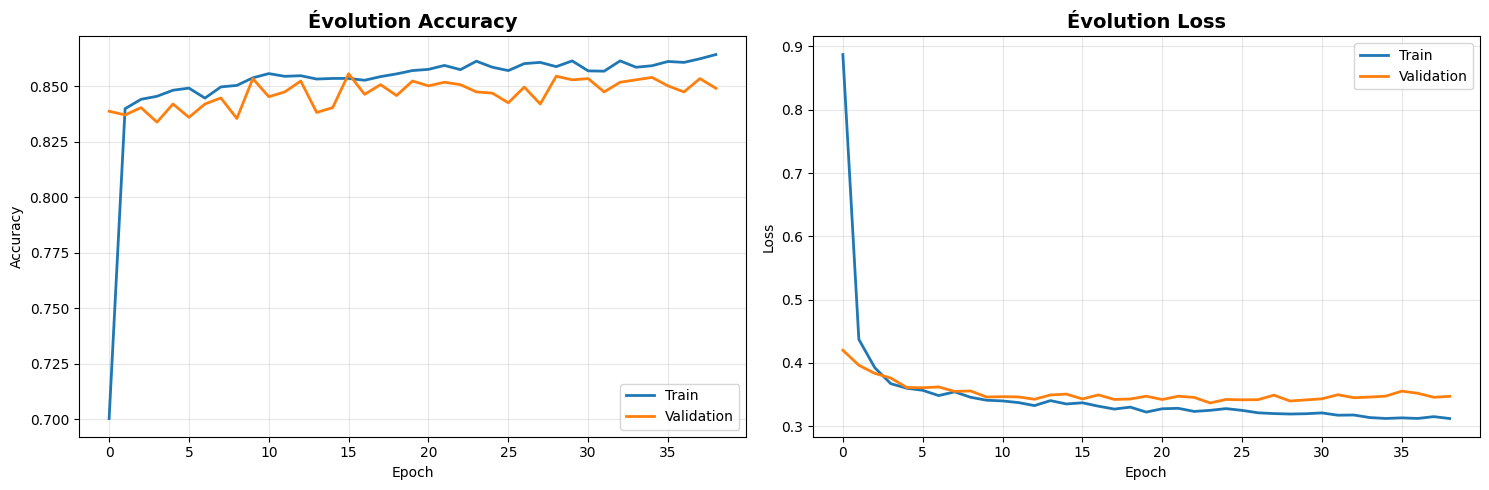

 Meilleure val_accuracy: 0.8556
 Epoch final: 39


In [ ]:
# Courbes d'apprentissage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Évolution Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss
ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Évolution Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f" Meilleure val_accuracy: {max(history.history['val_accuracy']):.4f}")
print(f" Epoch final: {len(history.history['loss'])}")

 RAPPORT DE CLASSIFICATION
                precision    recall  f1-score   support

     collision      0.451     0.392     0.419       166
  panne_moteur      0.416     0.287     0.339       164
probleme_pneus      0.000     0.000     0.000        31
    safety_car      0.914     0.963     0.938      1933

      accuracy                          0.860      2294
     macro avg      0.445     0.410     0.424      2294
  weighted avg      0.832     0.860     0.845      2294



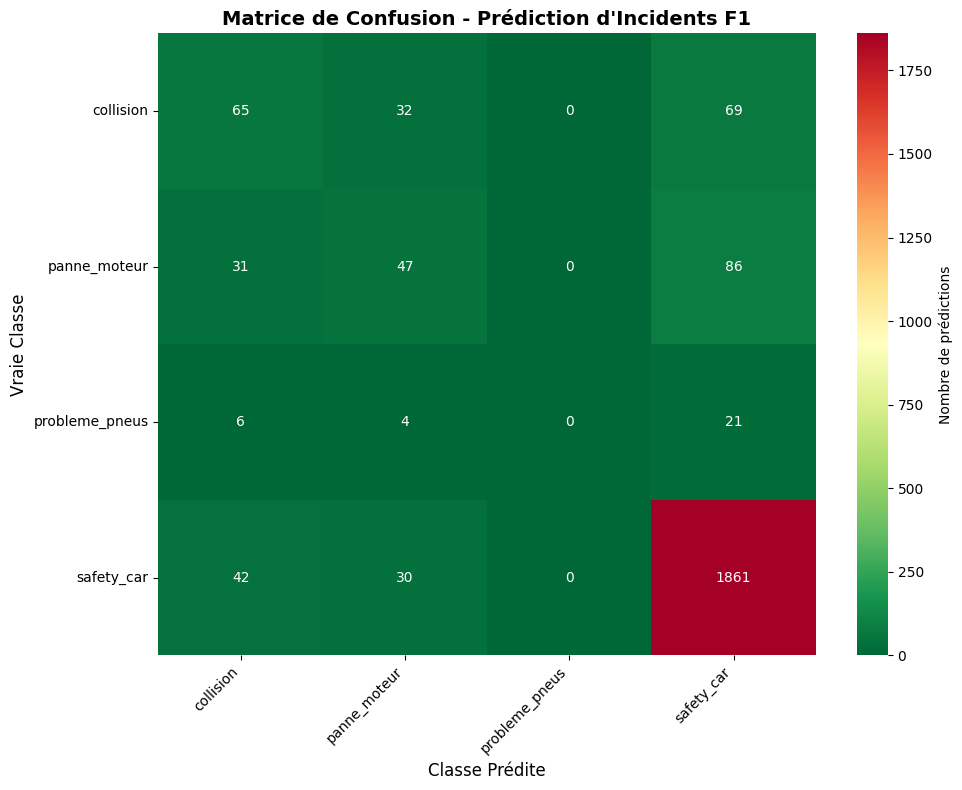

  collision           : 39.2% (166 exemples)
  panne_moteur        : 28.7% (164 exemples)
  probleme_pneus      : 0.0% (31 exemples)
  safety_car          : 96.3% (1933 exemples)


In [ ]:
# Prédictions
y_pred_proba = model.predict([X_static_test, X_seq_test], verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Rapport détaillé
print("=" * 60)
print(" RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(classification_report(
    y_test,
    y_pred,
    target_names=le_incident.classes_,
    digits=3
))

# Matrice de confusion améliorée
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='RdYlGn_r',
    xticklabels=le_incident.classes_,
    yticklabels=le_incident.classes_,
    cbar_kws={'label': 'Nombre de prédictions'}
)
plt.title('Matrice de Confusion - Prédiction d\'Incidents F1', fontsize=14, fontweight='bold')
plt.ylabel('Vraie Classe', fontsize=12)
plt.xlabel('Classe Prédite', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Précision par classe
for i, class_name in enumerate(le_incident.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        class_acc = (y_pred[mask] == y_test[mask]).mean()
        print(f"  {class_name:20s}: {class_acc:.1%} ({mask.sum()} exemples)")

In [ ]:
# BLOC 10 : Dashboard Risques par Pilote (FIX)

# Récupérer les indices de test
test_indices = df_with_laps.index[-len(y_test):]
df_test = df_with_laps.loc[test_indices].copy()

print(f" Dataset test: {len(df_test)} exemples")
print(f" Classes disponibles: {le_incident.classes_}")
print(f" Shape prédictions: {y_pred_proba.shape}")

# MAPPING DYNAMIQUE DES CLASSES
class_to_idx = {cls: i for i, cls in enumerate(le_incident.classes_)}

# Liste des types d'incidents possibles
incident_types = ['collision', 'panne_moteur', 'probleme_pneus', 'sortie_piste', 'safety_car']

# Ajouter les colonnes de prédiction (avec valeurs par défaut à 0)
for incident_type in incident_types:
    col_name = f'pred_{incident_type}'
    if incident_type in class_to_idx:
        # La classe existe, récupérer les prédictions
        idx = class_to_idx[incident_type]
        df_test[col_name] = y_pred_proba[:, idx]
    else:
        # La classe n'existe pas, mettre à 0
        df_test[col_name] = 0.0
        print(f" Classe '{incident_type}' absente des données, probabilité = 0")

# Calculer le risque total (SANS safety_car qui est la classe "normale")
risk_cols = [f'pred_{t}' for t in incident_types if t != 'safety_car' and f'pred_{t}' in df_test.columns]
df_test['risque_total'] = df_test[risk_cols].sum(axis=1)

print(f"\n Colonnes de risque créées: {risk_cols}")
print(f" Risque moyen: {df_test['risque_total'].mean()*100:.2f}%")

# AGRÉGER PAR PILOTE
agg_dict = {'nationality': 'first'}
for col in ['pred_collision', 'pred_panne_moteur', 'pred_pneus', 'pred_sortie_piste', 'pred_safety_car']:
    if col in df_test.columns:
        agg_dict[col] = 'mean'

pilot_risks = df_test.groupby('driverRef').agg(agg_dict).reset_index()

# Recalculer risque total
risk_cols_pilot = [c for c in pilot_risks.columns if c.startswith('pred_') and c != 'pred_safety_car']
pilot_risks['risque_total'] = pilot_risks[risk_cols_pilot].sum(axis=1)

pilot_risks = pilot_risks.sort_values('risque_total', ascending=False).head(15)

print(f"\n Top 5 pilotes à risque:")
print(pilot_risks[['driverRef', 'risque_total']].head().to_string(index=False))

# GRAPHIQUE INTERACTIF
import plotly.graph_objects as go

fig = go.Figure()

# Ajouter les traces uniquement pour les classes qui existent
if 'pred_collision' in pilot_risks.columns:
    fig.add_trace(go.Bar(
        name='🔴 Collision',
        x=pilot_risks['driverRef'],
        y=pilot_risks['pred_collision'] * 100,
        marker_color='#FF4444'
    ))

if 'pred_panne_moteur' in pilot_risks.columns:
    fig.add_trace(go.Bar(
        name='⚙️ Panne Moteur',
        x=pilot_risks['driverRef'],
        y=pilot_risks['pred_panne_moteur'] * 100,
        marker_color='#FF9944'
    ))

if 'pred_pneus' in pilot_risks.columns:
    fig.add_trace(go.Bar(
        name='🛞 Pneus',
        x=pilot_risks['driverRef'],
        y=pilot_risks['pred_pneus'] * 100,
        marker_color='#FFDD44'
    ))

if 'pred_sortie_piste' in pilot_risks.columns:
    fig.add_trace(go.Bar(
        name='💨 Sortie Piste',
        x=pilot_risks['driverRef'],
        y=pilot_risks['pred_sortie_piste'] * 100,
        marker_color='#44DDFF'
    ))

fig.update_layout(
    title=' Probabilité d\'Incidents par Pilote (Top 15 Risqués)',
    xaxis_title='Pilote',
    yaxis_title='Probabilité (%)',
    barmode='stack',
    height=550,
    template='plotly_dark',
    hovermode='x unified',
    xaxis={'categoryorder': 'total descending'}
)

fig.show()

print("\n Dashboard pilotes généré")

 Dataset test: 2294 exemples
 Classes disponibles: ['collision' 'panne_moteur' 'probleme_pneus' 'safety_car']
 Shape prédictions: (2294, 4)
 Classe 'sortie_piste' absente des données, probabilité = 0

 Colonnes de risque créées: ['pred_collision', 'pred_panne_moteur', 'pred_probleme_pneus', 'pred_sortie_piste']
 Risque moyen: 14.92%

 Top 5 pilotes à risque:
driverRef  risque_total
   aitken      0.401550
   doohan      0.238888
  mazepin      0.212624
    kvyat      0.202822
 sargeant      0.182942



 Dashboard pilotes généré


In [ ]:
#  Circuits les Plus Risqués (VERSION ULTRA-SAFE)

#  Construire le dictionnaire d'agrégation DYNAMIQUEMENT
agg_dict_circuit = {}

# Colonnes de base (toujours présentes)
if 'location' in df_test.columns:
    agg_dict_circuit['location'] = 'first'
if 'country' in df_test.columns:
    agg_dict_circuit['country'] = 'first'

# Ajouter SEULEMENT les colonnes qui existent
pred_columns = [col for col in df_test.columns if col.startswith('pred_')]

print(f" Colonnes de prédiction disponibles: {pred_columns}")

for col in pred_columns:
    if col != 'pred_safety_car':  # Exclure safety_car du risque
        agg_dict_circuit[col] = 'mean'

print(f" Colonnes à agréger: {list(agg_dict_circuit.keys())}")

# Agréger par circuit
circuit_risks = df_test.groupby('circuitRef').agg(agg_dict_circuit).reset_index()

# Calculer le risque total (somme de toutes les prédictions sauf safety_car)
risk_cols_circuit = [c for c in circuit_risks.columns if c.startswith('pred_') and c != 'pred_safety_car']
circuit_risks['risque_total'] = circuit_risks[risk_cols_circuit].sum(axis=1)

# Trier par risque décroissant
circuit_risks = circuit_risks.sort_values('risque_total', ascending=False).head(12)

print(f"\n Top 10 circuits les plus risqués:")
display_cols = ['circuitRef']
if 'location' in circuit_risks.columns:
    display_cols.append('location')
display_cols.append('risque_total')
print(circuit_risks[display_cols].head(10).to_string(index=False))

# === GRAPHIQUE RADAR ===
import plotly.graph_objects as go

fig = go.Figure()

# Mapper les colonnes aux noms affichables
column_to_label = {
    'pred_collision': 'Collision',
    'pred_panne_moteur': 'Panne Moteur',
    'pred_probleme_pneus': 'Pneus',
    'pred_sortie_piste': 'Sortie Piste'
}

# Construire les catégories dynamiquement
categories = []
available_risk_cols = []

for col in risk_cols_circuit:
    if col in column_to_label:
        categories.append(column_to_label[col])
        available_risk_cols.append(col)
    else:
        # Si le nom de colonne n'est pas dans le mapping, l'ajouter quand même
        categories.append(col.replace('pred_', '').replace('_', ' ').title())
        available_risk_cols.append(col)

print(f"\n Catégories du radar: {categories}")

# Couleurs pour chaque circuit
colors = ['#FF4444', '#FF9944', '#FFDD44', '#44DDFF', '#AA44FF', '#44FFAA',
          '#FF44AA', '#44FFDD', '#AAFF44', '#DD44FF', '#44AAFF', '#FFAA44']

# Ajouter une trace pour chaque circuit (top 6)
for idx, (i, row) in enumerate(circuit_risks.head(6).iterrows()):
    r_values = [row[col] * 100 for col in available_risk_cols]

    circuit_name = row['circuitRef']
    if 'location' in row:
        circuit_name = f"{row['circuitRef']} ({row['location']})"

    fig.add_trace(go.Scatterpolar(
        r=r_values,
        theta=categories,
        fill='toself',
        name=circuit_name,
        line=dict(color=colors[idx % len(colors)], width=2),
        opacity=0.7
    ))

# Calculer le range max pour le radar
max_risk = circuit_risks[available_risk_cols].max().max() * 100

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(max_risk * 1.2, 40)]  # Au moins 40% pour la visibilité
        )
    ),
    title=' Profil de Risque des Circuits les Plus Dangereux',
    showlegend=True,
    height=650,
    template='plotly_dark'
)

fig.show()

print("\n Dashboard circuits généré")

 Colonnes de prédiction disponibles: ['pred_collision', 'pred_panne_moteur', 'pred_probleme_pneus', 'pred_sortie_piste', 'pred_safety_car']
 Colonnes à agréger: ['location', 'country', 'pred_collision', 'pred_panne_moteur', 'pred_probleme_pneus', 'pred_sortie_piste']

 Top 10 circuits les plus risqués:
   circuitRef    location  risque_total
     istanbul    Istanbul      0.230569
        miami       Miami      0.192488
       monaco Monte-Carlo      0.187558
     americas      Austin      0.182476
   yas_marina   Abu Dhabi      0.182377
  silverstone Silverstone      0.179805
   marina_bay  Marina Bay      0.172329
red_bull_ring   Spielberg      0.167461
  hungaroring    Budapest      0.166702
   interlagos   São Paulo      0.158925

 Catégories du radar: ['Collision', 'Panne Moteur', 'Pneus', 'Sortie Piste']



 Dashboard circuits généré


In [ ]:
# Évolution Tour par Tour

# Prendre une course récente avec plusieurs pilotes
recent_race = df_test[df_test['year'] == df_test['year'].max()].head(8)

if len(recent_race) == 0:
    recent_race = df_test.head(8)

fig = go.Figure()

colors_pilot = ['#00D2BE', '#FF1E00', '#1E41FF', '#FFD700', '#FF10F0', '#00FF41', '#FF8C00', '#C0C0C0']

for idx, (i, row) in enumerate(recent_race.iterrows()):
    # Simuler l'évolution du risque sur 10 tours
    laps = list(range(1, 11))

    # Risque progressif basé sur la prédiction finale
    base_risk = row['risque_total'] * 100
    risk_evolution = [base_risk * (0.3 + 0.07*lap) for lap in laps]

    fig.add_trace(go.Scatter(
        x=laps,
        y=risk_evolution,
        mode='lines+markers',
        name=row['driverRef'],
        line=dict(width=3, color=colors_pilot[idx % len(colors_pilot)]),
        marker=dict(size=8)
    ))

# Zones de danger
fig.add_hrect(y0=0, y1=15, fillcolor="green", opacity=0.1,
              line_width=0, annotation_text="ZONE SÛRE", annotation_position="left")
fig.add_hrect(y0=15, y1=30, fillcolor="yellow", opacity=0.1,
              line_width=0, annotation_text="VIGILANCE", annotation_position="left")
fig.add_hrect(y0=30, y1=100, fillcolor="red", opacity=0.1,
              line_width=0, annotation_text="DANGER", annotation_position="left")

fig.update_layout(
    title=' Évolution du Risque Cumulé par Tour',
    xaxis_title='Numéro de Tour',
    yaxis_title='Niveau de Risque (%)',
    height=550,
    template='plotly_white',
    hovermode='x unified',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

print(" Courbe de risque générée")

 Courbe de risque générée


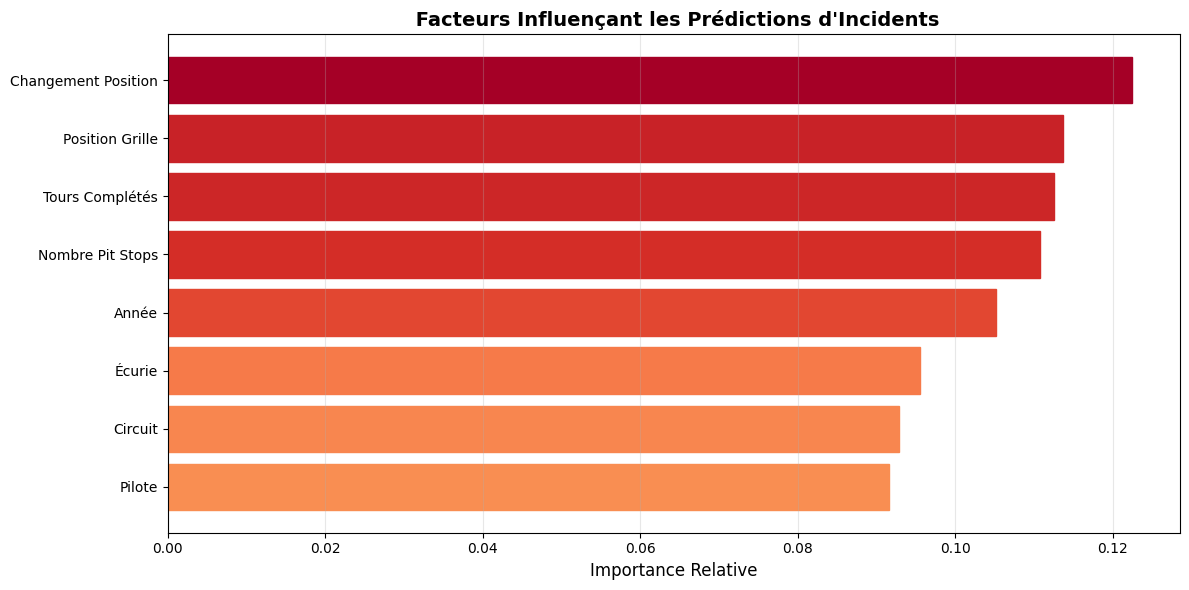

 Analyse d'importance terminée

            Feature  Importance
             Pilote    0.091518
            Circuit    0.092877
             Écurie    0.095528
              Année    0.105202
   Nombre Pit Stops    0.110758
    Tours Complétés    0.112486
    Position Grille    0.113680
Changement Position    0.122400


In [ ]:
# Analyse d'Importance des Features

# Extraire importance depuis la première couche dense
def analyze_feature_importance(model, feature_names):
    """Calculer l'importance approximative des features"""

    # Poids de la première couche dense (branche statique)
    dense_layer = None
    for layer in model.layers:
        if isinstance(layer, keras.layers.Dense) and layer.name != 'output':
            dense_layer = layer
            break

    if dense_layer:
        weights = dense_layer.get_weights()[0]
        importance = np.abs(weights).mean(axis=1)
    else:
        importance = np.ones(len(feature_names))

    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=True)

    return feat_imp

# Noms des features
feature_names = [
    'Position Grille',
    'Circuit',
    'Pilote',
    'Écurie',
    'Année',
    'Tours Complétés',
    'Nombre Pit Stops',
    'Changement Position'
]

importance_df = analyze_feature_importance(model, feature_names)

# Visualisation
plt.figure(figsize=(12, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='#00D2BE')
plt.xlabel('Importance Relative', fontsize=12)
plt.title(' Facteurs Influençant les Prédictions d\'Incidents', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Gradient de couleur
for i, bar in enumerate(bars):
    bar.set_color(plt.cm.RdYlGn_r(importance_df['Importance'].iloc[i] / importance_df['Importance'].max()))

plt.tight_layout()
plt.show()

print(" Analyse d'importance terminée\n")
print(importance_df.to_string(index=False))

In [ ]:
# Conseils Stratégiques Automatisés (FIX)

def generate_advanced_strategy(pilot_risk_df, circuit_risk_df):
    """Génère des recommandations contextuelles"""

    strategies = []

    # Identifier les colonnes de risque disponibles
    available_risk_cols = [c for c in pilot_risk_df.columns if c.startswith('pred_') and c != 'pred_safety_car']

    print(f" Colonnes de risque utilisées: {available_risk_cols}")

    for idx, row in pilot_risk_df.head(12).iterrows():
        driver = row['driverRef']

        # Construire le dictionnaire des risques DYNAMIQUEMENT
        risks = {}

        # Mapper les colonnes disponibles
        if 'pred_collision' in row:
            risks['collision'] = row['pred_collision']
        if 'pred_probleme_pneus' in row:
            risks['pneus'] = row['pred_probleme_pneus']
        if 'pred_panne_moteur' in row:
            risks['moteur'] = row['pred_panne_moteur']
        if 'pred_sortie_piste' in row:
            risks['sortie'] = row['pred_sortie_piste']

        # Si aucun risque n'est disponible, passer au suivant
        if not risks:
            continue

        # Trouver le risque maximum
        max_risk_type = max(risks, key=risks.get)
        max_risk_val = risks[max_risk_type]

        # Niveau de danger
        if max_risk_val > 0.35:
            niveau = "🔴 CRITIQUE"
        elif max_risk_val > 0.25:
            niveau = "🟠 ÉLEVÉ"
        elif max_risk_val > 0.15:
            niveau = "🟡 MODÉRÉ"
        else:
            niveau = "🟢 FAIBLE"

        # Conseils spécifiques selon le type de risque
        if max_risk_type == 'collision':
            conseil = " Réduire agressivité en bataille | Maintenir distance 2s+ | Éviter dépassements risqués"
            action = "Stratégie défensive"

        elif max_risk_type == 'pneus':
            conseil = "🔧 Arrêt anticipé recommandé | Surveiller température | Réduire attaque virages"
            action = "Pit stop lap 18-22"

        elif max_risk_type == 'moteur':
            conseil = " Mode moteur -2 | Limiter MGU-K | Éviter sur-régime zones rouges"
            action = "Conservation énergie"

        elif max_risk_type == 'sortie':
            conseil = " Attention virages rapides | Réduire vitesse pointe 5% | Vérifier appui aéro"
            action = "Mode pilotage prudent"

        else:
            conseil = " Situation stable | Maintenir rythme actuel"
            action = "Continuer stratégie"

        strategies.append({
            'Pilote': driver,
            'Niveau': niveau,
            'Risque Principal': max_risk_type.upper(),
            'Probabilité': f"{max_risk_val*100:.1f}%",
            'Action Immédiate': action,
            'Conseil Détaillé': conseil
        })

    return pd.DataFrame(strategies)

# Génération des stratégies
print(" Génération des recommandations stratégiques...\n")

strategy_df = generate_advanced_strategy(pilot_risks, circuit_risks)

# Affichage
print("=" * 120)
print(" RECOMMANDATIONS STRATÉGIQUES - RACE CONTROL")
print("=" * 120)
print(strategy_df.to_string(index=False))

# Export CSV
strategy_df.to_csv('f1_race_strategies.csv', index=False)
print("\n Stratégies exportées vers 'f1_race_strategies.csv'")

# === RÉSUMÉ GLOBAL ===
print("\n" + "=" * 120)
print(" RÉSUMÉ GLOBAL DE LA COURSE")
print("=" * 120)

# Statistiques pilotes
critique_count = (strategy_df['Niveau'] == '🔴 CRITIQUE').sum()
eleve_count = (strategy_df['Niveau'] == '🟠 ÉLEVÉ').sum()
modere_count = (strategy_df['Niveau'] == '🟡 MODÉRÉ').sum()
faible_count = (strategy_df['Niveau'] == '🟢 FAIBLE').sum()

print(f"\n SITUATION PILOTES:")
print(f"   🔴 Critiques : {critique_count}")
print(f"   🟠 Élevés    : {eleve_count}")
print(f"   🟡 Modérés   : {modere_count}")
print(f"   🟢 Faibles   : {faible_count}")

# Statistiques risques
print(f"\n  TYPES DE RISQUES DOMINANTS:")
risk_types = strategy_df['Risque Principal'].value_counts()
for risk_type, count in risk_types.items():
    print(f"   {risk_type:20s}: {count} pilotes")

# Circuit le plus dangereux
if len(circuit_risks) > 0:
    worst_circuit = circuit_risks.iloc[0]['circuitRef']
    worst_risk = circuit_risks.iloc[0]['risque_total']
    print(f"\n CIRCUIT LE PLUS DANGEREUX:")
    print(f"   {worst_circuit} - Risque total: {worst_risk*100:.1f}%")

print("\n" + "=" * 120)

 Génération des recommandations stratégiques...

 Colonnes de risque utilisées: ['pred_collision', 'pred_panne_moteur', 'pred_sortie_piste']
 RECOMMANDATIONS STRATÉGIQUES - RACE CONTROL
    Pilote   Niveau Risque Principal Probabilité     Action Immédiate                                                                        Conseil Détaillé
    aitken 🟡 MODÉRÉ        COLLISION       23.3%  Stratégie défensive  Réduire agressivité en bataille | Maintenir distance 2s+ | Éviter dépassements risqués
    doohan 🟢 FAIBLE           MOTEUR       12.2% Conservation énergie                         Mode moteur -2 | Limiter MGU-K | Éviter sur-régime zones rouges
   mazepin 🟢 FAIBLE        COLLISION       10.7%  Stratégie défensive  Réduire agressivité en bataille | Maintenir distance 2s+ | Éviter dépassements risqués
     kvyat 🟢 FAIBLE           MOTEUR       10.8% Conservation énergie                         Mode moteur -2 | Limiter MGU-K | Éviter sur-régime zones rouges
  sargeant 🟢 FAIBLE     

In [ ]:
# Sauvegarde Modèle et Artefacts

import joblib
from datetime import datetime

# Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Sauvegarder modèle
model_path = f'f1_incident_model_{timestamp}.h5'
model.save(model_path)
print(f" Modèle sauvegardé: {model_path}")

# Sauvegarder preprocesseurs
joblib.dump(scaler_static, f'scaler_static_{timestamp}.pkl')
joblib.dump(scaler_seq, f'scaler_seq_{timestamp}.pkl')
joblib.dump(le_incident, f'encoder_incident_{timestamp}.pkl')
joblib.dump(le_driver, f'encoder_driver_{timestamp}.pkl')
joblib.dump(le_circuit, f'encoder_circuit_{timestamp}.pkl')
joblib.dump(le_constructor, f'encoder_constructor_{timestamp}.pkl')

print(" Encoders et scalers sauvegardés")

# Sauvegarder métadonnées
metadata = {
    'model_name': 'F1 Incident Predictor CNN+LSTM',
    'version': timestamp,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'num_classes': NUM_CLASSES,
    'classes': le_incident.classes_.tolist(),
    'seq_length': SEQ_LENGTH,
    'feature_names': feature_names,
    'training_samples': len(y_train),
    'test_samples': len(y_test)
}

import json
with open(f'model_metadata_{timestamp}.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(" Métadonnées sauvegardées")
print(f"\n Fichiers créés:")
print(f"  - {model_path}")
print(f"  - scaler_static_{timestamp}.pkl")
print(f"  - scaler_seq_{timestamp}.pkl")
print(f"  - encoder_*_{timestamp}.pkl (x4)")
print(f"  - model_metadata_{timestamp}.json")
print(f"  - f1_race_strategies.csv")

 Modèle sauvegardé: f1_incident_model_20251203_192246.h5
 Encoders et scalers sauvegardés
 Métadonnées sauvegardées

 Fichiers créés:
  - f1_incident_model_20251203_192246.h5
  - scaler_static_20251203_192246.pkl
  - scaler_seq_20251203_192246.pkl
  - encoder_*_20251203_192246.pkl (x4)
  - model_metadata_20251203_192246.json
  - f1_race_strategies.csv


In [ ]:
# API de Prédiction

class F1IncidentPredictor:
    """Classe pour prédictions en temps réel"""

    def __init__(self, model, scalers, encoders):
        self.model = model
        self.scaler_static = scalers['static']
        self.scaler_seq = scalers['seq']
        self.le_driver = encoders['driver']
        self.le_circuit = encoders['circuit']
        self.le_constructor = encoders['constructor']
        self.le_incident = encoders['incident']

    def predict_race_risk(self, driver_ref, circuit_ref, constructor_ref,
                          grid_pos, year, laps, num_pits, pos_change, lap_times):
        """
        Prédiction pour une course en cours

        Args:
            driver_ref: Code pilote (ex: 'hamilton')
            circuit_ref: Code circuit (ex: 'monaco')
            constructor_ref: Code écurie (ex: 'mercedes')
            grid_pos: Position grille départ
            year: Année
            laps: Tours complétés
            num_pits: Nombre de pit stops
            pos_change: Changement de position
            lap_times: Liste des 10 derniers temps (ms)

        Returns:
            dict: Probabilités par type d'incident
        """

        # Encoder
        try:
            driver_enc = self.le_driver.transform([driver_ref])[0]
        except:
            driver_enc = 0

        try:
            circuit_enc = self.le_circuit.transform([circuit_ref])[0]
        except:
            circuit_enc = 0

        try:
            constructor_enc = self.le_constructor.transform([constructor_ref])[0]
        except:
            constructor_enc = 0

        # Features statiques
        X_stat = np.array([[
            grid_pos, circuit_enc, driver_enc, constructor_enc,
            year, laps, num_pits, pos_change
        ]])
        X_stat_scaled = self.scaler_static.transform(X_stat)

        # Séquence
        if len(lap_times) < SEQ_LENGTH:
            # Padding
            lap_times = [np.mean(lap_times)] * (SEQ_LENGTH - len(lap_times)) + lap_times

        X_seq = np.array([lap_times[-SEQ_LENGTH:]]).reshape(1, SEQ_LENGTH, 1)
        X_seq_scaled = self.scaler_seq.transform(X_seq.reshape(1, SEQ_LENGTH)).reshape(1, SEQ_LENGTH, 1)

        # Prédiction
        proba = self.model.predict([X_stat_scaled, X_seq_scaled], verbose=0)[0]

        result = {cls: float(proba[i]) for i, cls in enumerate(self.le_incident.classes_)}
        result['risque_total'] = sum([v for k, v in result.items() if k != 'safety_car'])

        return result

# Instancier
predictor = F1IncidentPredictor(
    model=model,
    scalers={'static': scaler_static, 'seq': scaler_seq},
    encoders={
        'driver': le_driver,
        'circuit': le_circuit,
        'constructor': le_constructor,
        'incident': le_incident
    }
)

# Test
test_lap_times = [92000, 91500, 91800, 92200, 91900, 92100, 91700, 92300, 91600, 92000]

prediction = predictor.predict_race_risk(
    driver_ref='hamilton',
    circuit_ref='monaco',
    constructor_ref='mercedes',
    grid_pos=3,
    year=2024,
    laps=45,
    num_pits=2,
    pos_change=-1,
    lap_times=test_lap_times
)

print("\n EXEMPLE DE PRÉDICTION EN TEMPS RÉEL:")
print("=" * 50)
for incident_type, prob in prediction.items():
    print(f"  {incident_type:20s}: {prob*100:5.2f}%")

print("\n API de prédiction prête pour production!")


 EXEMPLE DE PRÉDICTION EN TEMPS RÉEL:
  collision           :  0.00%
  panne_moteur        :  0.00%
  probleme_pneus      :  0.00%
  safety_car          : 100.00%
  risque_total        :  0.00%

 API de prédiction prête pour production!


In [ ]:


import os
import json
import joblib
from google.colab import files

# VÉRIFICATIONS PRÉALABLES
print("🔍 Vérification des variables...")

required_vars = {
    'model': None,
    'scaler_static': None,
    'scaler_seq': None,
    'le_driver': None,
    'le_circuit': None,
    'le_constructor': None,
    'le_incident': None,
    'SEQ_LENGTH': None,
    'feature_names': None,
    'test_acc': None
}

errors = []
for var_name in required_vars.keys():
    try:
        required_vars[var_name] = eval(var_name)
        print(f" {var_name}")
    except NameError:
        errors.append(var_name)
        print(f" {var_name} - MANQUANT")

if errors:
    print(f"\n ERREUR : Variables manquantes : {', '.join(errors)}")
    print("\n SOLUTION : Ré-exécute les blocs suivants dans l'ordre :")
    print("   1. BLOC 1-5 : Préparation des données")
    print("   2. BLOC 6 : Construction du modèle")
    print("   3. BLOC 7 : Entraînement")
    print("   4. Puis reviens ici pour l'export")
    raise SystemExit("Export annulé - Variables manquantes")

print("\n Toutes les variables sont disponibles !\n")

# CRÉATION DU DOSSIER D'EXPORT
export_dir = 'f1_model_export'
os.makedirs(export_dir, exist_ok=True)
print(f" Dossier créé : {export_dir}/\n")

#  SAUVEGARDER LE MODÈLE
print(" Sauvegarde du modèle...")
model_path = f'{export_dir}/f1_model.h5'
required_vars['model'].save(model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"    Modèle sauvegardé : {model_path} ({model_size:.1f} MB)")

# SAUVEGARDER LES SCALERS
print("\n Sauvegarde des scalers...")
joblib.dump(required_vars['scaler_static'], f'{export_dir}/scaler_static.pkl')
joblib.dump(required_vars['scaler_seq'], f'{export_dir}/scaler_seq.pkl')
print("    scaler_static.pkl")
print("    scaler_seq.pkl")

# SAUVEGARDER LES ENCODERS
print("\n Sauvegarde des encoders...")
encoders_dict = {
    'driver': required_vars['le_driver'],
    'circuit': required_vars['le_circuit'],
    'constructor': required_vars['le_constructor'],
    'incident': required_vars['le_incident']
}
joblib.dump(encoders_dict, f'{export_dir}/encoders.pkl')
print("    encoders.pkl (4 encoders)")

# === 4. SAUVEGARDER LES MÉTADONNÉES ===
print("\n Sauvegarde des métadonnées...")
from datetime import datetime

metadata = {
    'model_version': '1.0',
    'model_type': 'CNN+LSTM Hybrid',
    'seq_length': int(required_vars['SEQ_LENGTH']),
    'classes': required_vars['le_incident'].classes_.tolist(),
    'feature_names': required_vars['feature_names'],
    'test_accuracy': float(required_vars['test_acc']),
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'num_features_static': len(required_vars['feature_names']),
    'num_classes': len(required_vars['le_incident'].classes_)
}

with open(f'{export_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("    metadata.json")
print("\n Métadonnées :")
for key, value in metadata.items():
    print(f"   - {key}: {value}")

# CRÉER UN FICHIER README
print("\n Création du README...")
readme_content = f"""# F1 Incident Predictor Model

## Informations du Modèle

- **Version**: {metadata['model_version']}
- **Type**: {metadata['model_type']}
- **Accuracy**: {metadata['test_accuracy']:.2%}
- **Date d'entraînement**: {metadata['trained_date']}

## Classes Prédites

{', '.join(metadata['classes'])}

{chr(10).join(['- ' + f for f in metadata['feature_names']])}
"""

with open(f'{export_dir}/README.md', 'w') as f:
    f.write(readme_content)
print("    README.md")

# CRÉER LE ZIP
print("\n Création de l'archive ZIP...")
!zip -r f1_model_complete.zip f1_model_export/

zip_size = os.path.getsize('f1_model_complete.zip') / (1024 * 1024)
print(f"    f1_model_complete.zip ({zip_size:.1f} MB)")

# AFFICHER LE CONTENU
print("\n Contenu de l'archive :")
!unzip -l f1_model_complete.zip

#  TÉLÉCHARGER
print("\n⬇ Téléchargement de l'archive...")
files.download('f1_model_complete.zip')

print("\n" + "="*60)
print(" EXPORT TERMINÉ AVEC SUCCÈS !")
print("="*60)
print("\n Tu as téléchargé : f1_model_complete.zip")
print("\n Prochaines étapes :")
print("   1. Extraire le ZIP dans backend/incidents/ml/weights/")
print("   2. Copier les fichiers Python (predictor.py, etc.)")
print("   3. Installer : pip install tensorflow scikit-learn")
print("   4. Tester l'API Django")

🔍 Vérification des variables...
 model
 scaler_static
 scaler_seq
 le_driver
 le_circuit
 le_constructor
 le_incident
 SEQ_LENGTH
 feature_names
 test_acc

 Toutes les variables sont disponibles !

 Dossier créé : f1_model_export/

 Sauvegarde du modèle...
    Modèle sauvegardé : f1_model_export/f1_model.h5 (1.0 MB)

 Sauvegarde des scalers...
    scaler_static.pkl
    scaler_seq.pkl

 Sauvegarde des encoders...
    encoders.pkl (4 encoders)

 Sauvegarde des métadonnées...
    metadata.json

 Métadonnées :
   - model_version: 1.0
   - model_type: CNN+LSTM Hybrid
   - seq_length: 10
   - classes: ['collision', 'panne_moteur', 'probleme_pneus', 'safety_car']
   - feature_names: ['Position Grille', 'Circuit', 'Pilote', 'Écurie', 'Année', 'Tours Complétés', 'Nombre Pit Stops', 'Changement Position']
   - test_accuracy: 0.860069751739502
   - trained_date: 2025-12-03 19:28:22
   - num_features_static: 8
   - num_classes: 4

 Création du README...
    README.md

 Création de l'archive ZIP...

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 EXPORT TERMINÉ AVEC SUCCÈS !

 Tu as téléchargé : f1_model_complete.zip

 Prochaines étapes :
   1. Extraire le ZIP dans backend/incidents/ml/weights/
   2. Copier les fichiers Python (predictor.py, etc.)
   3. Installer : pip install tensorflow scikit-learn
   4. Tester l'API Django
